# Inference on image DINO + SAM

### Loading DINO

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
# Grounding DINO
from groundingdino.util.inference import load_image

# Set working directory as the main directory. Write you main directory here
os.chdir("...")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use CUDA.

In [2]:
import torch
# Use CUDA if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Load the model.

In [3]:
from utils.setup_dino import load_model_hf

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/home/ubuntu/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/ubuntu/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### Load the image

Here we load one of the images of our dataset.

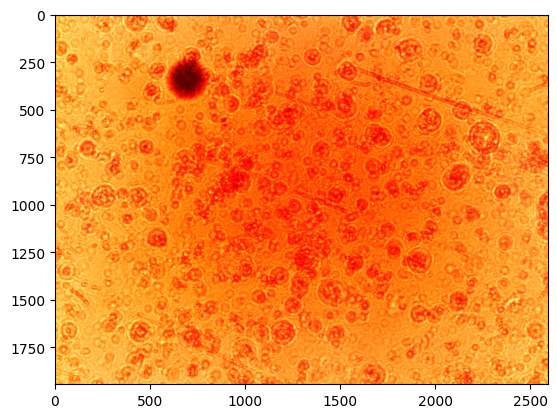

In [4]:
# Local image path
data_path = '.../data/'
image_source, image = load_image(os.path.join(data_path, "img_name.png"))

# Plot image
plt.imshow(image_source, cmap='gray')  

### DINO inference

Detect the boxes with Grounding DINO

/home/ubuntu/venv/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Filtered number of boxes was 46 , after Big Box Overlap Filtering is 33


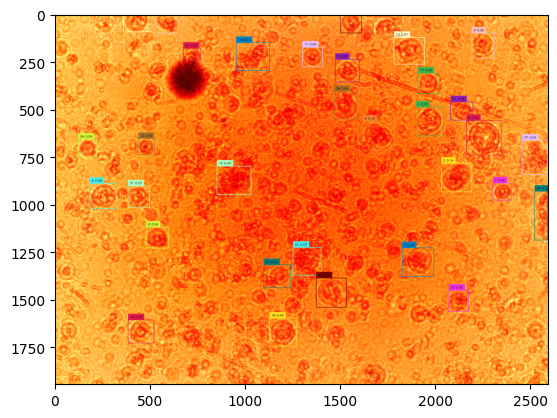

In [5]:
from utils.inference_dino import detect

# text_prompt = "dark circles"
text_prompt = "dark rounds"
# Parameters bn without contrast
annotated_frame, detected_boxes = detect(image, image_source, text_prompt=text_prompt, model=groundingdino_model,
                                         box_threshold = 0.02, text_threshold = 0.2, stride_distance = 0.02,
                                         NMS = False, threshold_nms=0.5)

# Show boxes found on the image
plt.imshow(annotated_frame, cmap='gray')  

## SAM implementation

### Loading SAM

In [6]:
from transformers import SamModel, SamProcessor

# Use large encoder here
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

### Inference with SAM

Use the detected boxes with DINO as prompt to SAM.

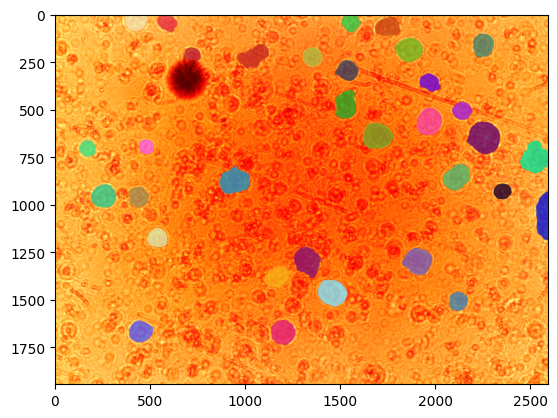

In [7]:
from utils.inference_sam import sam_inference_from_dino

# Detect all masks, scores and get the annotated frame
masks, scores, annotated_masks = sam_inference_from_dino(image_source, detected_boxes, 
                                                         model, processor, device)
# Plot the annotated frame
plt.imshow(annotated_masks, cmap='gray')  
